# ICR - Identifying Age-Related Conditions
Вихляев Е.С., ММТ-21. Итоговый проект по дисциплине «Методы машинного обучения».

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree  import DecisionTreeClassifier

### Задача

Определить, есть ли у человека какое-либо их трех заболеваний. Метка класса 1 соответствует тому, что есть хотя бы одно заболевание, а метка класса 0 соответствует тому, что заболеваний нет.

### Описание датасета

- train.csv - тренировочный набор.
    - Id - уникальный идентификатор для каждого наблюдения.
    - AB-GL - 56 обезличенных характеристик здоровья. Каждая из них числовая, за исключением EJ, которая является категориальной.
    - Class - целевая переменная. 1 указывает на то, что у испытуемого было диагностировано одно из трех заболеваний, 0 указывает на то, что у него заболеваний нет.
- test.csv - тестовый набор. Нужно предсказать вероятность того, что испытуемый из этого набора принадлежит к одному из двух классов.
- greeks.csv - дополнительные метаданные, доступные только для тренировочного набора.
    - Alpha - определяет тип возрастного заболевания, если таковое имеется.
        - A - нет возрастных изменений. Соответствует классу 0.
        - B, D, G - три возрастных изменения. Соответствует классу 1.
    - Beta, Gamma, Delta - три эксперементальных характеристики.
    - Epsilon - дата, когда были собраны данные по данному субъекту. Обратите внимание, что все данные в тестовом наборе были собраны после того, как был собран тренировочный набор данных.
- sample_submission.csv - образец файла для отправки в нужном формате.

[Источник](https://www.kaggle.com/competitions/icr-identify-age-related-conditions/overview).

### Загрузка датасета

In [2]:
df = pd.read_csv('train.csv')
print('Полный размер тренировочного датасета:', df.shape)

Полный размер тренировочного датасета: (617, 58)


Имеем 58 столбцов и 617 записей.

In [3]:
df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


Видим, что в датасете явно выделена целевая переменная class, по которой и будем проводить классификацию. Здесь метка класса 1 указывает, есть ли у человека одно или более из представленных трех заболеваний. Метка класса 0 указывает, что у человека нет ни одного из трех заболеваний.

### EDA

In [4]:
df.describe(include='all')

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
unique,617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,000ff2bfdfe9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,NaN,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,NaN,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,NaN,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,NaN,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,NaN,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

Посмотрим на круговую диаграмму распределения целевой переменной.

<Axes: ylabel='count'>

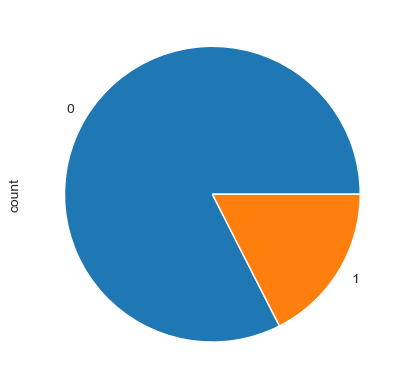

In [6]:
plot_df = df.Class.value_counts()
plot_df.plot(kind='pie')

Из диаграммы видим, что наш датасет имеет сильный дисбаланс классов в пользу метки класса 1.

Далее рассмотрим распределение числовых данных.

Для начала выделим все численные столбцы наших признаков, то есть исключим из рассмотрения очевидные числовые столбцы как Id, EJ и столбец целевой переменной Class.

In [7]:
num_feature_columns = [i for i in df.columns if i not in ['Id', 'EJ', 'Class']]
#num_feature_columns

Изобразим первые 6 числовых столбца и их значения через bag charts.

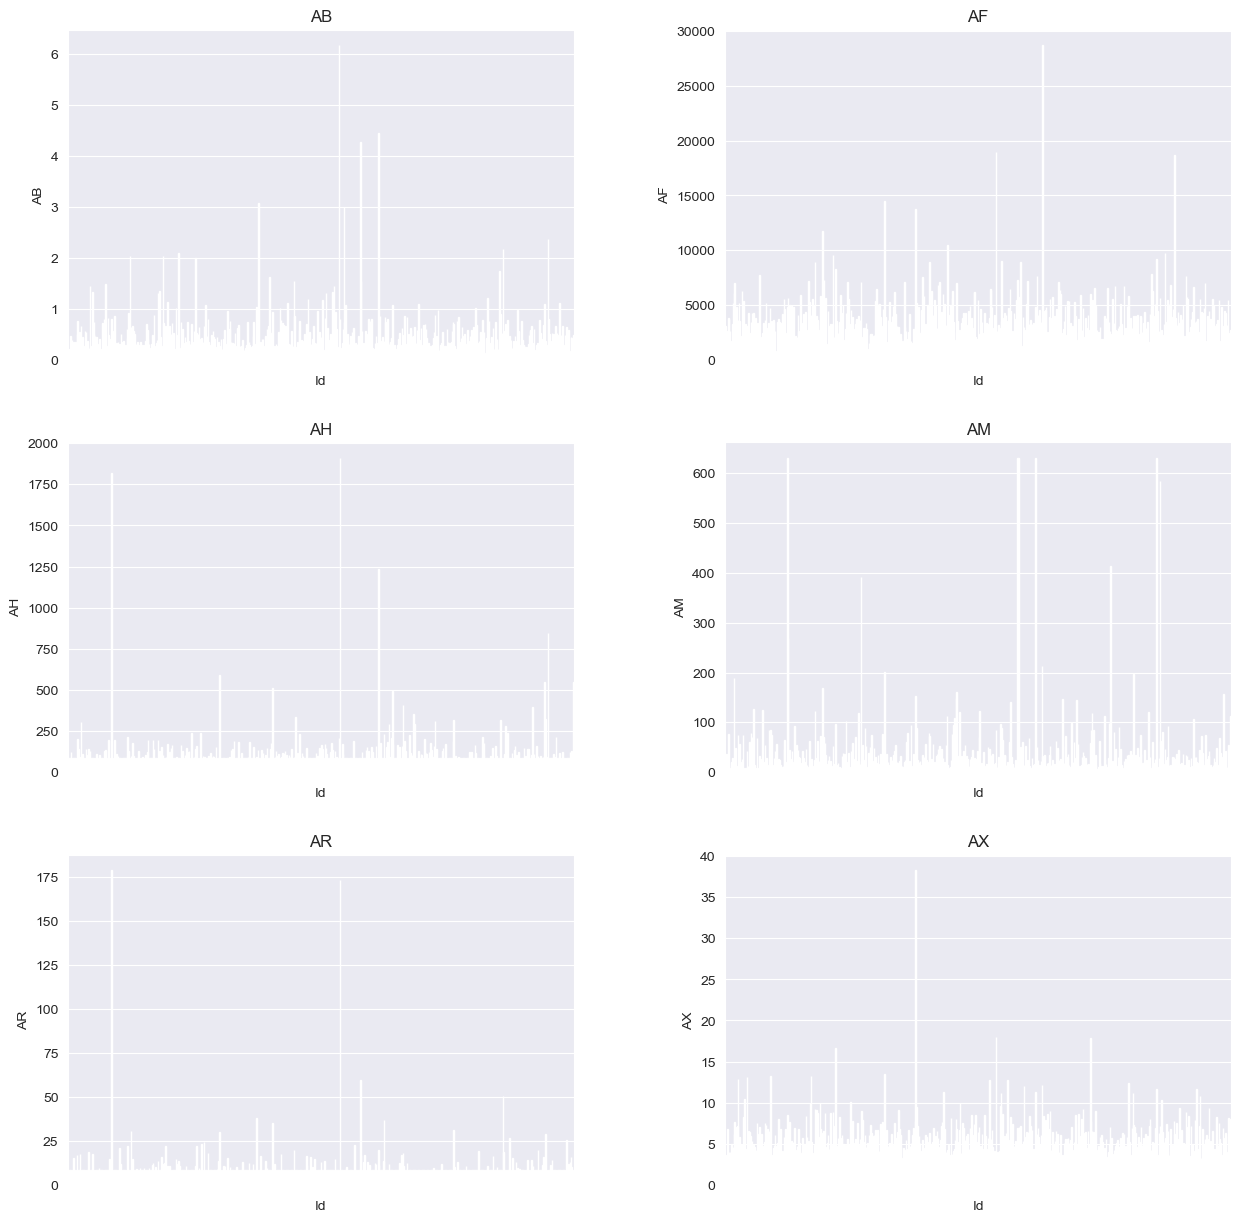

In [8]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(num_feature_columns[:6]):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=df['Id'], y = df[column_name], color='white')
    bp.set(xticklabels=[])
    axis[row, col].set_title(column_name)

plt.show()

Так же выделим столбцы признаков отдельно.

In [9]:
feature_columns = [i for i in df.columns if i not in ['Id']]
#feature_columns

### Пропущенные значения

Рассмотрим пропущенные значения.

In [10]:
print(df.isnull().sum())

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64


In [11]:
print(df.isnull().sum().sum())

131


Как мы видим, всего в датафрейме 131 пропуск. Определим, случайны ли наши пропуски или нет.

In [12]:
import missingno as msno
sns.set()

<Axes: >

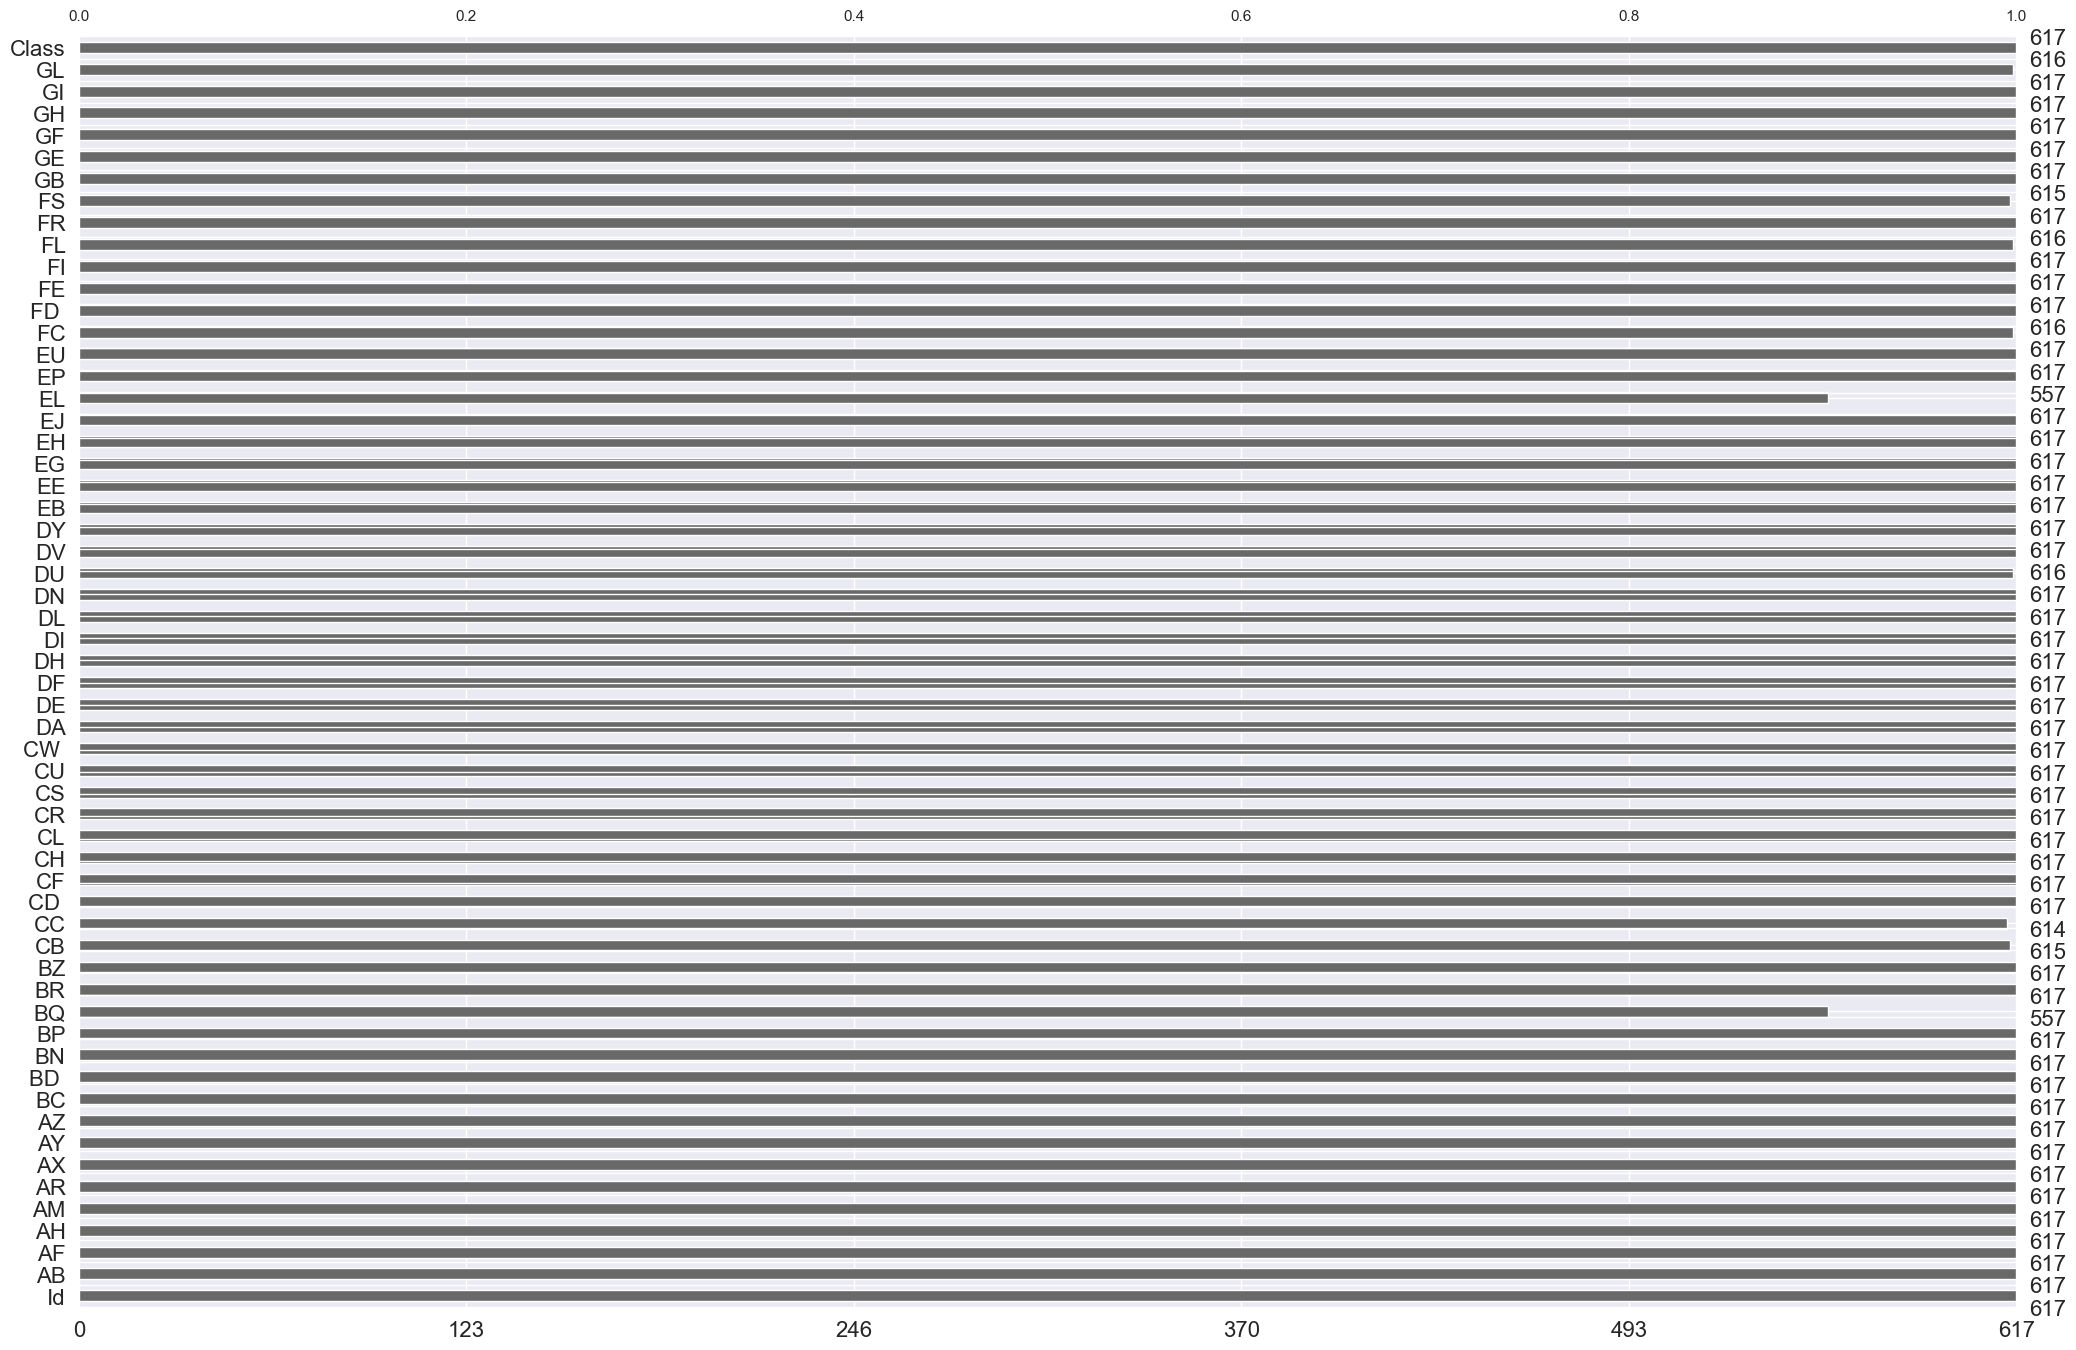

In [13]:
msno.bar(df)

<Axes: >

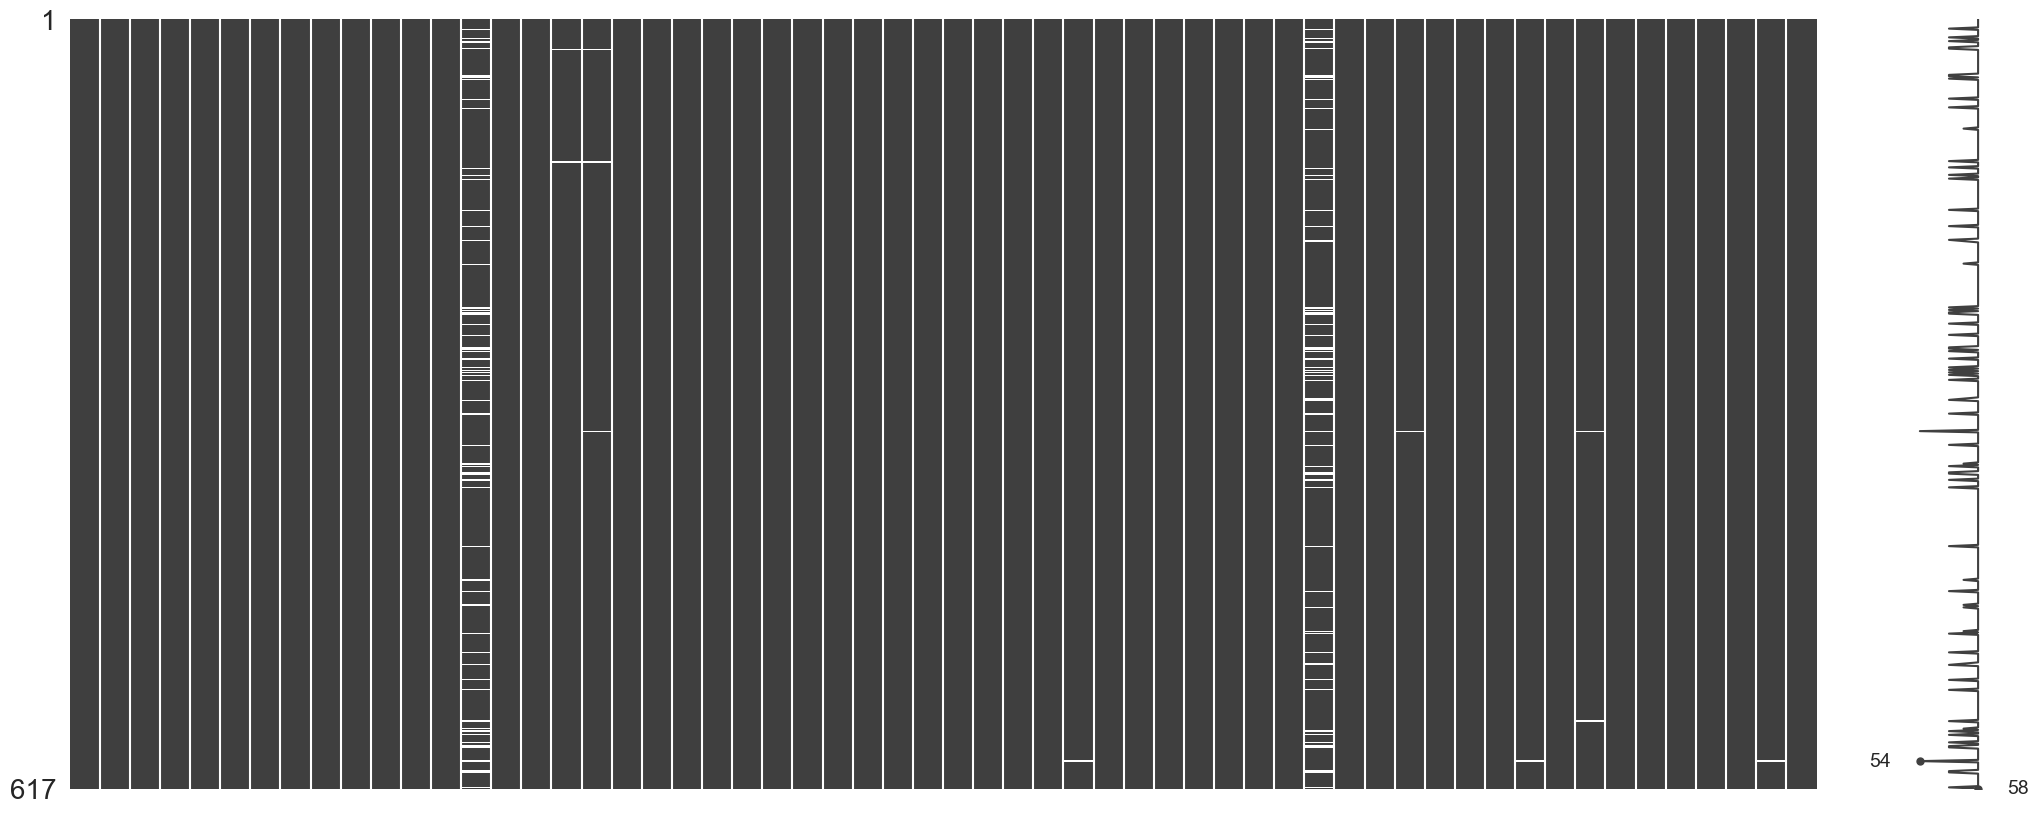

In [14]:
msno.matrix(df)

In [15]:
missing_columns = df.columns[df.isnull().any()].tolist()
print("Столбцы с пропущенными значениями:", missing_columns)

Столбцы с пропущенными значениями: ['BQ', 'CB', 'CC', 'DU', 'EL', 'FC', 'FL', 'FS', 'GL']


In [16]:
miss = df.columns[df.isnull().any()]

In [17]:
df[miss].isnull().corr()

,BQ,CB,CC,DU,EL,FC,FL,FS,GL
BQ,1.000000,-0.018717,-0.022942,0.122761,0.870766,-0.013224,0.122761,0.077518,0.122761
CB,-0.018717,1.000000,0.815832,-0.002298,-0.018717,-0.002298,-0.002298,-0.003252,-0.002298
CC,-0.022942,0.815832,1.000000,-0.002816,0.055697,0.576412,-0.002816,0.405923,-0.002816
DU,0.122761,-0.002298,-0.002816,1.000000,-0.013224,-0.001623,1.000000,-0.002298,1.000000
EL,0.870766,-0.018717,0.055697,-0.013224,1.000000,0.122761,-0.013224,0.077518,-0.013224
FC,-0.013224,-0.002298,0.576412,-0.001623,0.122761,1.000000,-0.001623,0.706533,-0.001623
FL,0.122761,-0.002298,-0.002816,1.000000,-0.013224,-0.001623,1.000000,-0.002298,1.000000
FS,0.077518,-0.003252,0.405923,-0.002298,0.077518,0.706533,-0.002298,1.000000,-0.002298
GL,0.122761,-0.002298,-0.002816,1.000000,-0.013224,-0.001623,1.000000,-0.002298,1.000000


In [18]:
df['EJ'].isnull().any().sum()

0

В единственном категориальном признаке пропуски отсутствуют. Это упрощает работу.

<Axes: >

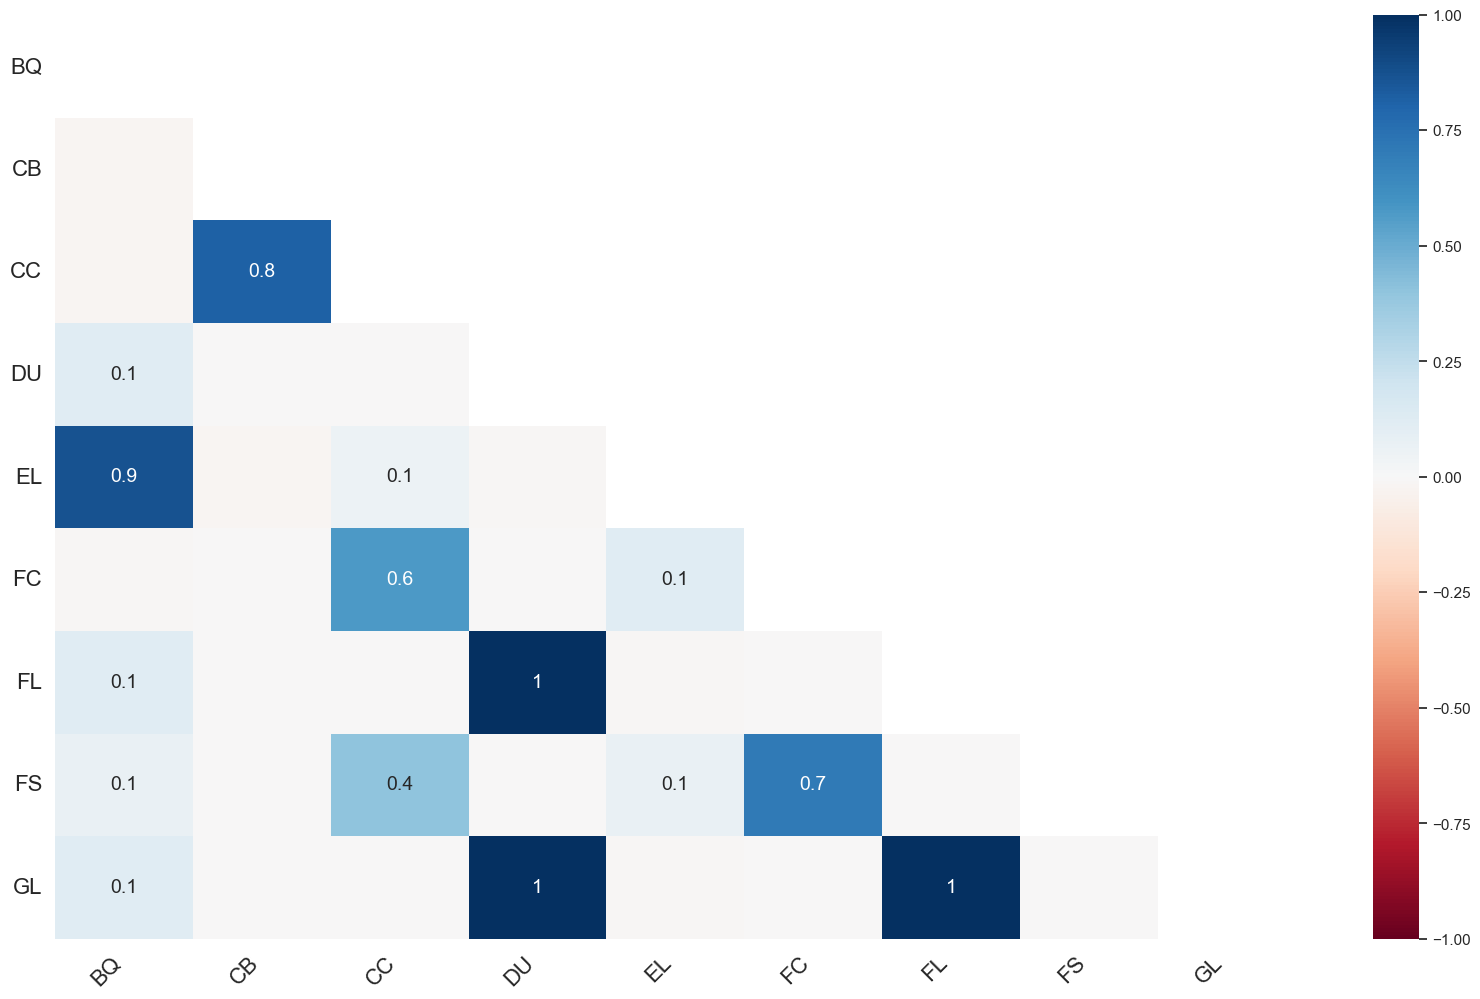

In [19]:
msno.heatmap(df)

Итак, видим, что три признака (DU, FL, GL) коррелируют с максимальным коэффицентом 1, признаки EL, CC, CB BQ коррелируют с очень высокими коэффициентами, еще FS, CC, FC коррелируют с серьзными коэффициентами. Иными словами, корреляция присутствует и достаточно сильная.

Соответственно, удалять пропуски в нашем случае — совершенно не вариант. **Значит их следует заменить.** Замене подлежат: DU, FL, GL, EL, CC, CB, BQ, FS, FC.

Поскольку признаки отражают некоторые характеристики здоровья, то мы можем заменить пропуски средним арифметическим или медианой. Как говорится, «средняя температура по больнице». Но здесь сушествует два важных момента:

1. Среднее значение может не отражать истинное состояние данных, если они содержат выбросы или имеют сильно ассиметричное распределение. Это может привести к искажению результатов.
2. Медиана же менее чувствительна к выбросам, а потому может быть более подходящей, если у данных ассиметричное распределение.

Проверим выбросы.

<Axes: >

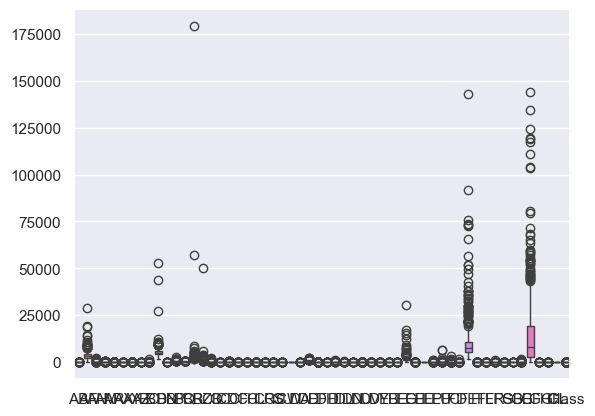

In [20]:
sns.boxplot(df)

In [21]:
def find_outliers_iqr(df):
    outlier_counts = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]
    
    return outlier_counts

df_outliers = df.drop('Id', axis=1)

# Выявление выбросов
element_counts = {column: len(df_outliers[column]) for column in df_outliers.columns}
print("Количество элементов в каждом столбце:")
print(element_counts)
outliers_iqr = find_outliers_iqr(df)
print("Количество выбросов в каждом столбце:")
print(outliers_iqr)

Количество элементов в каждом столбце:
{'AB': 617, 'AF': 617, 'AH': 617, 'AM': 617, 'AR': 617, 'AX': 617, 'AY': 617, 'AZ': 617, 'BC': 617, 'BD ': 617, 'BN': 617, 'BP': 617, 'BQ': 617, 'BR': 617, 'BZ': 617, 'CB': 617, 'CC': 617, 'CD ': 617, 'CF': 617, 'CH': 617, 'CL': 617, 'CR': 617, 'CS': 617, 'CU': 617, 'CW ': 617, 'DA': 617, 'DE': 617, 'DF': 617, 'DH': 617, 'DI': 617, 'DL': 617, 'DN': 617, 'DU': 617, 'DV': 617, 'DY': 617, 'EB': 617, 'EE': 617, 'EG': 617, 'EH': 617, 'EJ': 617, 'EL': 617, 'EP': 617, 'EU': 617, 'FC': 617, 'FD ': 617, 'FE': 617, 'FI': 617, 'FL': 617, 'FR': 617, 'FS': 617, 'GB': 617, 'GE': 617, 'GF': 617, 'GH': 617, 'GI': 617, 'GL': 617, 'Class': 617}
Количество выбросов в каждом столбце:
{'AB': 35, 'AF': 19, 'AH': 70, 'AM': 54, 'AR': 133, 'AX': 27, 'AY': 107, 'AZ': 14, 'BC': 45, 'BD ': 15, 'BN': 14, 'BP': 33, 'BQ': 48, 'BR': 47, 'BZ': 116, 'CB': 47, 'CC': 25, 'CD ': 37, 'CF': 38, 'CH': 30, 'CL': 74, 'CR': 31, 'CS': 31, 'CU': 21, 'CW ': 0, 'DA': 19, 'DE': 38, 'DF': 137, '

Выбросов достаточно много, поэтому воспользуемся заменой на медиану. Замене подлежат: DU, FL, GL, EL, CC, CB, BQ, FS, FC.

In [22]:
from sklearn.impute import SimpleImputer

print('Пропусков до заполнения их медианой:', df.isna().sum().sum())
imp_median = SimpleImputer(strategy = 'median')
df[['DU', 'FL', 'GL', 'EL', 'CC', 'CB', 'BQ', 'FS', 'FC']] = imp_median.fit_transform(df[['DU', 'FL', 'GL', 'EL', 'CC', 'CB', 'BQ', 'FS', 'FC']])
print('Пропусков после их заполнения медианой: ', df.isna().sum().sum())

Пропусков до заполнения их медианой: 131
Пропусков после их заполнения медианой:  0


### Корреляционный анализ

In [23]:
df_without_id_and_ej = df.drop(['Id', 'EJ'], axis=1)
df_without_id_and_ej

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


<Axes: >

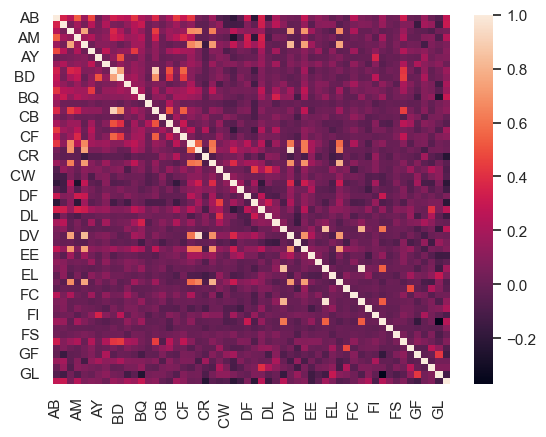

In [24]:
sns.heatmap(df_without_id_and_ej.corr())

Автоматизируем определение тех признаков, которые имеют высокую корреляцию. В качестве порогового значения будет 0.75.

In [25]:
threshold = 0.75
corr_matrix = df_without_id_and_ej.corr()

correlated_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

correlated_features

{'BD ', 'BZ', 'DV', 'EH', 'EP', 'FD '}

У нас есть 6 признаков с высокой корреляцией. Поскольку их корреляция друг с другом как бы заслоняет их влияние на целевую переменную, она может привести к переобучению и снижению интерпретируемости модели. Их следует удалить.

In [26]:
df = df.drop(columns = correlated_features)
df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


Так же рассмотрим и корреляцию признаков с таргетом.

In [27]:
from scipy.stats import pointbiserialr

df_numeric = df.drop(columns = ['Id', 'EJ'])

# Рассчитаем корреляцию Пирсона для количественных признаков с бинарной целевой переменной
correlations = {}
for col in df_numeric.columns:
    corr, _ = pointbiserialr(df[col], df_numeric['Class'])
    correlations[col] = abs(corr)

# Сортировка признаков по важности
sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
print("Корреляция с целевым признаком (бинарная классификация):")
print(sorted_corr)

Корреляция с целевым признаком (бинарная классификация):
[('Class', 0.9999999999999989), ('AF', 0.30263845295706243), ('BQ', 0.29390449868980767), ('AB', 0.2806118820146079), ('DU', 0.26107762079887226), ('DI', 0.2607598057198681), ('FL', 0.2442911214674431), ('AM', 0.23916993156241648), ('CR', 0.22754659276787176), ('FE', 0.21635913044648228), ('DH', 0.2068392454005762), ('DA', 0.20461203708587059), ('BN', 0.1982828887610545), ('CD ', 0.17130354932075287), ('BP', 0.1572864429090943), ('BC', 0.1558815349542316), ('DL', 0.14771602038439643), ('EE', 0.13532354428920085), ('GF', 0.12820803405020612), ('DE', 0.12497729147482393), ('GL', 0.11852787883158403), ('CF', 0.10974774612045446), ('FR', 0.10409912152603562), ('AX', 0.09761578296404434), ('FI', 0.09432709836698461), ('BR', 0.0885535625511284), ('EB', 0.08800491810535993), ('GB', 0.08334316250342867), ('CU', 0.08318486460783596), ('AY', 0.08242036653398181), ('GI', 0.07689351926655302), ('GE', 0.07076554123410937), ('EL', 0.0644546940

In [28]:
# Отбор признаков с корреляцией |r| > 0.3
selected_features = [feature for feature, corr in correlations.items() if corr > 0.3]

print("Отобранные признаки с корреляцией |r| > 0.3:", selected_features)

Отобранные признаки с корреляцией |r| > 0.3: ['AF', 'Class']


Тут следует учитывать важную особенность наших данных. Поскольку они медицинские, то низкая корреляция ожидаема! Медицинские данные часто имеют сложные, многофакторные отношения. Заболевания могут быть вызваны множеством факторов, и их взаимодействие может не быть линейным. Поэтому опустим порог до 0.1.

In [29]:
# Отбор признаков с корреляцией |r| > 0.3
selected_features = [feature for feature, corr in correlations.items() if corr > 0.1]

print("Отобранные признаки с корреляцией |r| > 0.1:", selected_features)

Отобранные признаки с корреляцией |r| > 0.1: ['AB', 'AF', 'AM', 'BC', 'BN', 'BP', 'BQ', 'CD ', 'CF', 'CR', 'DA', 'DE', 'DH', 'DI', 'DL', 'DU', 'EE', 'FE', 'FL', 'FR', 'GF', 'GL', 'Class']


In [30]:
print(len(selected_features))

23


In [31]:
df_numeric_reduced = df_numeric[selected_features]
df_numeric_reduced

,AB,AF,AM,BC,BN,BP,BQ,CD,CF,CR,...,DI,DL,DU,EE,FE,FL,FR,GF,GL,Class
0,0.209377,3109.03329,22.394407,5.555634,22.5984,175.638726,152.707705,23.387600,4.851915,0.069225,...,89.245560,84.31664,5.310690,1.987283,9028.291921,7.298162,1.73855,2003.810319,0.120343,1
1,0.145282,978.76416,36.968889,1.229900,19.4205,155.868030,14.754720,50.628208,6.085041,1.117800,...,110.581815,75.74548,0.005518,0.858603,6785.003474,0.173229,0.49706,27981.562750,21.978000,0
2,0.470030,2635.10654,32.360553,1.229900,26.4825,128.988531,219.320160,85.955376,5.376488,0.700350,...,120.056438,65.46984,1.289739,8.146651,8338.906181,7.709560,0.97556,13676.957810,0.196941,0
3,0.252107,3819.65177,77.112203,1.229900,23.6577,237.282264,11.050410,88.159360,2.347652,0.636075,...,139.824570,71.57120,2.655345,3.813326,10965.766040,6.122162,0.49706,2094.262452,0.155829,0
4,0.380297,3733.04844,14.103738,102.151980,24.0108,324.546318,149.717165,72.644264,30.537722,0.693150,...,97.920120,52.83888,1.144902,3.490846,16198.049590,8.153058,48.50134,8524.370502,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,9.513984,2.804172,21.1860,167.877117,27.287375,55.163024,4.780452,0.698250,...,176.977590,90.91832,0.005518,1.354416,17167.209610,0.173229,1.26092,8095.932828,21.978000,0
613,0.435846,5462.03438,46.551007,3.777550,27.1887,285.628059,344.644105,85.233928,6.682597,0.761025,...,192.598575,123.17624,0.648318,0.753797,18460.330020,10.223150,1.24236,3085.308063,0.145340,0
614,0.427300,2459.10720,55.355778,1.229900,20.4798,178.661133,103.988995,142.680216,7.809288,0.879825,...,218.915925,326.23620,0.005518,2.225112,5088.922912,0.173229,0.49706,6474.652866,21.978000,0
615,0.363205,1263.53524,23.685856,1.229900,19.0674,119.162529,61.642115,122.939496,2.964975,0.583125,...,113.526045,96.97092,0.510378,1.628524,6464.250832,9.256996,0.78764,1965.343176,0.184622,0


### Работа с категориальными признаками

Колонка id нам и вовсе не нужна, поэтому просто удалим ее и добавим обратно EJ.

In [32]:
df_reduced = df_numeric_reduced.join(df['EJ'])
df_reduced

,AB,AF,AM,BC,BN,BP,BQ,CD,CF,CR,...,DL,DU,EE,FE,FL,FR,GF,GL,Class,EJ
0,0.209377,3109.03329,22.394407,5.555634,22.5984,175.638726,152.707705,23.387600,4.851915,0.069225,...,84.31664,5.310690,1.987283,9028.291921,7.298162,1.73855,2003.810319,0.120343,1,B
1,0.145282,978.76416,36.968889,1.229900,19.4205,155.868030,14.754720,50.628208,6.085041,1.117800,...,75.74548,0.005518,0.858603,6785.003474,0.173229,0.49706,27981.562750,21.978000,0,A
2,0.470030,2635.10654,32.360553,1.229900,26.4825,128.988531,219.320160,85.955376,5.376488,0.700350,...,65.46984,1.289739,8.146651,8338.906181,7.709560,0.97556,13676.957810,0.196941,0,B
3,0.252107,3819.65177,77.112203,1.229900,23.6577,237.282264,11.050410,88.159360,2.347652,0.636075,...,71.57120,2.655345,3.813326,10965.766040,6.122162,0.49706,2094.262452,0.155829,0,B
4,0.380297,3733.04844,14.103738,102.151980,24.0108,324.546318,149.717165,72.644264,30.537722,0.693150,...,52.83888,1.144902,3.490846,16198.049590,8.153058,48.50134,8524.370502,0.096614,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,9.513984,2.804172,21.1860,167.877117,27.287375,55.163024,4.780452,0.698250,...,90.91832,0.005518,1.354416,17167.209610,0.173229,1.26092,8095.932828,21.978000,0,A
613,0.435846,5462.03438,46.551007,3.777550,27.1887,285.628059,344.644105,85.233928,6.682597,0.761025,...,123.17624,0.648318,0.753797,18460.330020,10.223150,1.24236,3085.308063,0.145340,0,B
614,0.427300,2459.10720,55.355778,1.229900,20.4798,178.661133,103.988995,142.680216,7.809288,0.879825,...,326.23620,0.005518,2.225112,5088.922912,0.173229,0.49706,6474.652866,21.978000,0,A
615,0.363205,1263.53524,23.685856,1.229900,19.0674,119.162529,61.642115,122.939496,2.964975,0.583125,...,96.97092,0.510378,1.628524,6464.250832,9.256996,0.78764,1965.343176,0.184622,0,B


In [33]:
print(df_reduced.dtypes)

AB       float64
AF       float64
AM       float64
BC       float64
BN       float64
BP       float64
BQ       float64
CD       float64
CF       float64
CR       float64
DA       float64
DE       float64
DH       float64
DI       float64
DL       float64
DU       float64
EE       float64
FE       float64
FL       float64
FR       float64
GF       float64
GL       float64
Class      int64
EJ        object
dtype: object


Для кодирования категориальных данных воспользуемся методом One-Hot.

In [34]:
df_encoded = pd.get_dummies(df_reduced, columns=['EJ'])
df_encoded.replace({True: 1, False: 0})

/var/folders/cr/0fzq0bwx2pngt4ykckw13q1c0000gn/T/ipykernel_4322/2865506304.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded.replace({True: 1, False: 0})


,AB,AF,AM,BC,BN,BP,BQ,CD,CF,CR,...,DU,EE,FE,FL,FR,GF,GL,Class,EJ_A,EJ_B
0,0.209377,3109.03329,22.394407,5.555634,22.5984,175.638726,152.707705,23.387600,4.851915,0.069225,...,5.310690,1.987283,9028.291921,7.298162,1.73855,2003.810319,0.120343,1,0,1
1,0.145282,978.76416,36.968889,1.229900,19.4205,155.868030,14.754720,50.628208,6.085041,1.117800,...,0.005518,0.858603,6785.003474,0.173229,0.49706,27981.562750,21.978000,0,1,0
2,0.470030,2635.10654,32.360553,1.229900,26.4825,128.988531,219.320160,85.955376,5.376488,0.700350,...,1.289739,8.146651,8338.906181,7.709560,0.97556,13676.957810,0.196941,0,0,1
3,0.252107,3819.65177,77.112203,1.229900,23.6577,237.282264,11.050410,88.159360,2.347652,0.636075,...,2.655345,3.813326,10965.766040,6.122162,0.49706,2094.262452,0.155829,0,0,1
4,0.380297,3733.04844,14.103738,102.151980,24.0108,324.546318,149.717165,72.644264,30.537722,0.693150,...,1.144902,3.490846,16198.049590,8.153058,48.50134,8524.370502,0.096614,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,9.513984,2.804172,21.1860,167.877117,27.287375,55.163024,4.780452,0.698250,...,0.005518,1.354416,17167.209610,0.173229,1.26092,8095.932828,21.978000,0,1,0
613,0.435846,5462.03438,46.551007,3.777550,27.1887,285.628059,344.644105,85.233928,6.682597,0.761025,...,0.648318,0.753797,18460.330020,10.223150,1.24236,3085.308063,0.145340,0,0,1
614,0.427300,2459.10720,55.355778,1.229900,20.4798,178.661133,103.988995,142.680216,7.809288,0.879825,...,0.005518,2.225112,5088.922912,0.173229,0.49706,6474.652866,21.978000,0,1,0
615,0.363205,1263.53524,23.685856,1.229900,19.0674,119.162529,61.642115,122.939496,2.964975,0.583125,...,0.510378,1.628524,6464.250832,9.256996,0.78764,1965.343176,0.184622,0,0,1


#### Распределение данных

Посмотрим так же распределение данных.

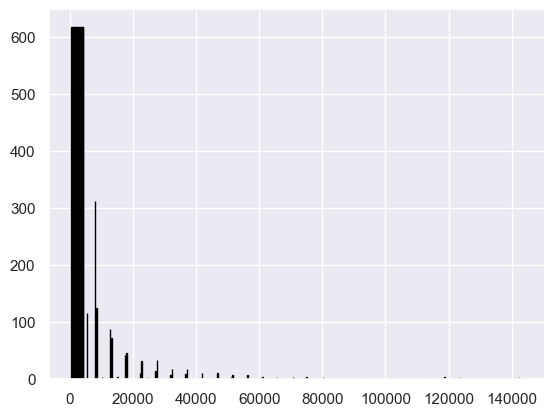

In [35]:
plt.hist(df_encoded, bins=30, edgecolor='black')
plt.show()

Наше распределение в больше степени похоже на экспоненциальное. Воспользуемся логарифмическим преобразованием, чтобы приблизить его к нормальному распределению. Поскольку одними из наших моделей будут kNN и логистическая регрессия, то с распределением следует что-то сделать. Поскольку в экспоненциальном распределении есть много маленьких значений и несколько больших, то это может привести к тому, что модель будет сосредотачиваться на большем количестве мелких значений и игнорировать редкие, но важные. В то же время, линейные модели, kNN, SVM — чувствительны к масштабированию и распределению данных, а значит могут выдать искаженные результаты.


In [36]:
X = df_encoded.drop(columns=['Class'])
y = df['Class']

X_log = np.log1p(X)
X_log

,AB,AF,AM,BC,BN,BP,BQ,CD,CF,CR,...,DL,DU,EE,FE,FL,FR,GF,GL,EJ_A,EJ_B
0,0.190105,8.042389,3.152497,1.880325,3.161179,5.174107,5.035053,3.194075,1.766769,0.066934,...,4.446370,1.842245,1.094364,9.108229,2.116034,1.007429,7.603305,0.113635,0.000000,0.693359
1,0.135651,6.887312,3.636767,0.801957,3.016539,5.055405,2.757140,3.944068,1.957986,0.750378,...,4.340494,0.005502,0.619825,8.822617,0.159760,0.403503,10.239337,3.134537,0.693359,0.000000
2,0.385283,7.877058,3.507374,0.801957,3.313549,4.867446,5.395082,4.465395,1.852617,0.530834,...,4.196748,0.828438,2.213388,9.028807,2.164421,0.680852,9.523541,0.179769,0.000000,0.693359
3,0.224828,8.248176,4.358146,0.801957,3.205089,5.473456,2.489099,4.490425,1.208259,0.492300,...,4.284568,1.296190,1.571388,9.302625,1.963211,0.403503,7.647434,0.144817,0.000000,0.693359
4,0.322299,8.225248,2.714942,4.636203,3.219308,5.785505,5.015405,4.299246,3.451184,0.526591,...,3.985996,0.763094,1.502041,9.692708,2.214088,3.902000,9.050802,0.092228,0.000000,0.693359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.139375,8.049127,2.352706,1.336098,3.099461,5.129171,3.342416,4.028259,1.754482,0.529598,...,4.520900,0.005502,0.856293,9.750815,0.159760,0.815772,8.999241,3.134537,0.693359,0.000000
613,0.361754,8.605760,3.861803,1.563928,3.338921,5.658185,5.845410,4.457064,2.038958,0.565896,...,4.821702,0.499755,0.561783,9.823434,2.417979,0.807529,8.034731,0.135702,0.000000,0.693359
614,0.355785,7.807960,4.031685,0.801957,3.067113,5.191072,4.653856,4.967590,2.175807,0.631179,...,5.790682,0.005502,1.170968,8.535018,0.159760,0.403503,8.775805,3.134537,0.693359,0.000000
615,0.309839,7.142460,3.206230,0.801957,2.999097,4.788845,4.137438,4.819794,1.377500,0.459401,...,4.584671,0.412360,0.966422,8.774197,2.327960,0.580896,7.583931,0.169423,0.000000,0.693359


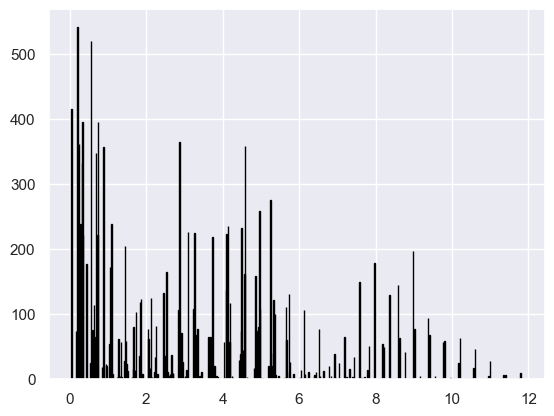

In [37]:
plt.hist(X_log, bins=30, edgecolor='black')
plt.show()

Ситуация улучшилась, но все равно выглядит не очень.

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_log_scaler = scaler.fit_transform(X_log)

# Преобразуем результат обратно в DataFrame с теми же именами столбцов
X_log_scaled = pd.DataFrame(X_log_scaler, columns=X.columns)

X_log_scaled

,AB,AF,AM,BC,BN,BP,BQ,CD,CF,CR,...,DL,DU,EE,FE,FL,FR,GF,GL,EJ_A,EJ_B
0,-0.793051,0.110642,-0.067111,0.687285,0.384228,-0.334638,0.910058,-2.704642,-0.654541,-3.202882,...,-0.191621,1.830990,-0.440427,0.207783,0.843536,0.506545,-0.819140,-0.880087,-0.749683,0.749683
1,-1.045391,-1.520469,0.506365,-0.682888,-0.477229,-0.605475,-1.306854,-1.032230,-0.388691,1.388379,...,-0.498191,-0.695211,-1.480201,-0.228882,-1.062163,-0.798943,0.974516,1.255450,1.333896,-1.333896
2,0.111391,-0.122825,0.353137,-0.682888,1.291729,-1.034331,1.260446,0.130278,-0.535185,-0.086479,...,-0.914421,0.436630,2.011492,0.086357,0.890673,-0.199406,0.487461,-0.833335,-0.749683,0.749683
3,-0.632149,0.401240,1.360629,-0.682888,0.645752,0.348374,-1.567717,0.186093,-1.431043,-0.345344,...,-0.660131,1.079963,0.604792,0.504990,0.694665,-0.798943,-0.789113,-0.858043,-0.749683,0.749683
4,-0.180474,0.368863,-0.585267,4.188900,0.730436,1.060361,0.890937,-0.240218,1.687317,-0.114985,...,-1.524672,0.346758,0.452843,1.101378,0.939055,6.763652,0.165792,-0.895220,-0.749683,0.749683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,-1.028134,0.120157,-1.014230,-0.004208,0.016645,-0.437165,-0.737251,-0.844494,-0.671624,-0.094781,...,0.024189,-0.695211,-0.962072,1.190216,-1.062163,0.092246,0.130708,1.255450,1.333896,-1.333896
613,0.002361,0.906192,0.772855,0.285272,1.442840,0.769862,1.698714,0.111700,-0.276115,0.149061,...,0.895185,-0.015430,-1.607379,1.301241,1.137675,0.074427,-0.525581,-0.864487,-0.749683,0.749683
614,-0.025302,-0.220400,0.974030,-0.682888,-0.176018,-0.295928,0.539069,1.250124,-0.085853,0.587619,...,3.700949,-0.695211,-0.272580,-0.668586,-1.062163,-0.798943,-0.021327,1.255450,1.333896,-1.333896
615,-0.238214,-1.160169,-0.003480,-0.682888,-0.581116,-1.213672,0.036481,0.920552,-1.195746,-0.566356,...,0.208841,-0.135631,-0.720764,-0.302911,1.049984,-0.415477,-0.832323,-0.840648,-0.749683,0.749683


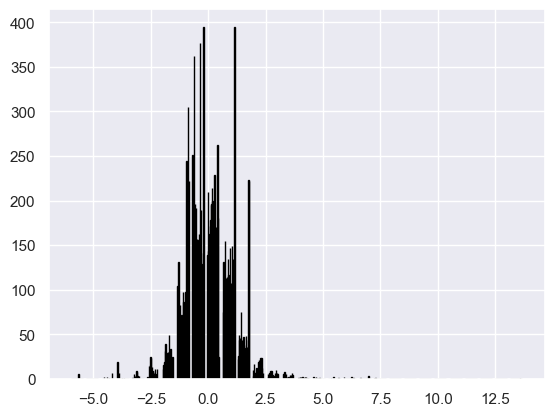

In [39]:
plt.hist(X_log_scaled, bins=30, edgecolor='black')
plt.show()

Теперь распределение больше похоже на нормальное.

#### Undersampling

In [40]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = rus.fit_resample(X_log_scaled, y)

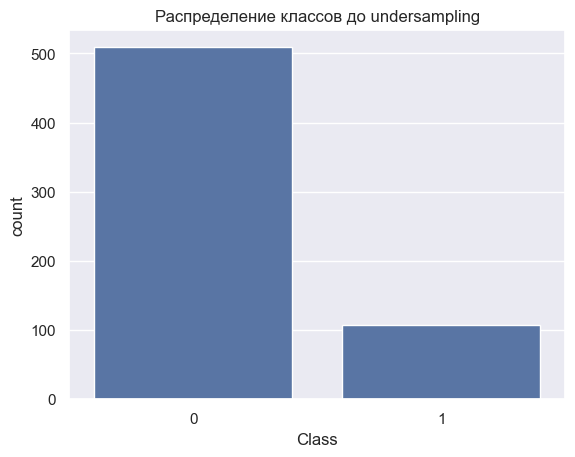

In [41]:
# Визуализация до undersampling
sns.countplot(x='Class', data=df_encoded)
plt.title('Распределение классов до undersampling')
plt.show()

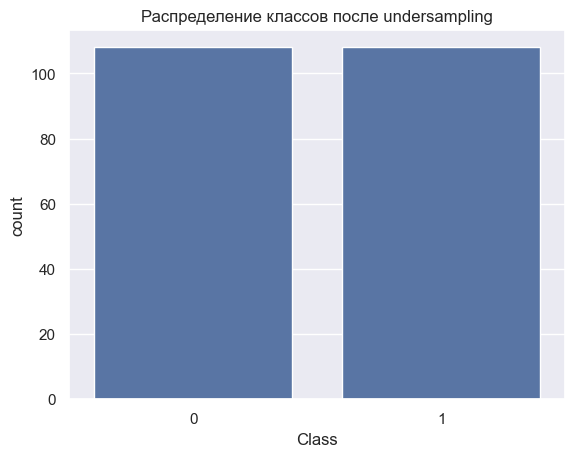

In [42]:
# Визуализация после undersampling
sns.countplot(x=y_resampled)
plt.title('Распределение классов после undersampling')
plt.show()

# Выбор метрик

#### Для классификации:

1. **Accuracy (точность).** Доля правильных предсказаний от общего числа предсказаний. Дает общее представление о производительности классификатора, но может ввести в заблуждение при дисбалансе классов.
2. **Recall (полнота).** Доля правильно классифицированных положительных случаев от общего числа положительных случаев. Важна в контексте медицинских данных, где пропуск положительного случая может иметь критические последствия.
3. **Precision (точность).** Доля правильно классифицированных положительных случаев относительно общего числа предсказанных положительных случаев. Полезна при диагностике, когда важно, чтобы положительный результат теста действительно означал наличие болезни.
4. **$F_1$-мера.** Гармоническое среднее точности и полноты. Полезна для сбалансированной оценки, особенно при дисбалансе классов.
5. **ROC-AUC.** Площадь под кривой ROC. Позволяет оценить модель при различных порогах и отлично подходит для бинарной классификации.

#### Для кластеризации:

1. **Silhouette Coefficient.** Измеряет, насколько близко объекты в одном кластере находятся к другим объектам в этом же кластере по сравнению с объектами в других кластерах. Значения от -1 до 1. Хорошо показывает, насколько четко разделены кластеры. Чем ближе к 1, тем лучше.
2. **Intra-cluster Distance (внутрикластерная дисперсия).** Среднее расстояние между всеми точками в кластере. Чем меньше, тем лучше. Дает представление о сжатии кластеров. Чем меньше, тем лучше.
3. **Inter-cluster Distance (межклассовая дисперсия).** Среднее расстояние между центрами кластеров. Чем больше, тем лучше. Позволяет понять, насколько кластеры отдалены друг от друга.
4. **DBI (Dunn's Index).** Соотношение межклассовой и внутриклассовой дисперсий, полезно для оценки качества кластеров. Позволяет оценить качество кластеров, объединяя информацию о внутриклассовой и межклассовой дисперсиях.

# Построение моделей

В качестве моделей для классификации выберем логистическую регрессию, дерево решений и случайный лес. В качестве моделей для кластеризации рассмотрим kNN и DBSCAN.

In [43]:
from sklearn.model_selection import train_test_split

X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

def classification_metrics(y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    print('Accuracy:', accuracy)
    print('Classification Report:', class_report)
    print('ROC AUC:', roc_auc)

In [45]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances

def clustering_metrics(X, labels):
    silhouette_avg = silhouette_score(X, labels)
    
    intra_cluster_distances = []
    for cluster in set(labels):
        cluster_points = X[labels == cluster]
        if len(cluster_points) > 1:
            intra_cluster_distance = pairwise_distances(cluster_points).mean()
            intra_cluster_distances.append(intra_cluster_distance)
    intra_cluster_distance_avg = np.mean(intra_cluster_distances) if intra_cluster_distances else None
    
    inter_cluster_distances = []
    cluster_centers = []
    for cluster in set(labels):
        cluster_points = X[labels == cluster]
        cluster_center = cluster_points.mean(axis=0)
        cluster_centers.append(cluster_center)
    inter_cluster_distances = pairwise_distances(cluster_centers)
    inter_cluster_distance_avg = np.mean(inter_cluster_distances) if len(cluster_centers) > 1 else None
    
    db_index = davies_bouldin_score(X, labels)
    
    print('Silhouette Score', silhouette_avg)
    print('Intra-cluster Distance', intra_cluster_distance_avg)
    print('Inter-cluster Distance', inter_cluster_distance_avg)
    print('Davies-Bouldin Index', db_index)

#### 1. Логистическая регрессия

In [46]:
logReg_resampled = LogisticRegression()
logReg_resampled.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [47]:
y_pred_logReg = logReg_resampled.predict(X_test_resampled)
y_prob_logReg = logReg_resampled.predict_proba(X_test_resampled)[:, 1]

In [48]:
classification_metrics(y_test_resampled, y_pred_logReg, y_prob_logReg)

Accuracy: 0.9545454545454546
Classification Report:               precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.96      0.96      0.96        27

    accuracy                           0.95        44
   macro avg       0.95      0.95      0.95        44
weighted avg       0.95      0.95      0.95        44

ROC AUC: 0.9934640522875817


#### 2. Дерево решений

In [49]:
dt_resampled = DecisionTreeClassifier(random_state=42)
dt_resampled.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [50]:
y_pred_dt = dt_resampled.predict(X_test_resampled)
y_prob_dt = dt_resampled.predict_proba(X_test_resampled)[:, 1]

In [51]:
classification_metrics(y_test_resampled, y_pred_dt, y_prob_dt)

Accuracy: 0.7954545454545454
Classification Report:               precision    recall  f1-score   support

           0       0.72      0.76      0.74        17
           1       0.85      0.81      0.83        27

    accuracy                           0.80        44
   macro avg       0.78      0.79      0.79        44
weighted avg       0.80      0.80      0.80        44

ROC AUC: 0.7897603485838779


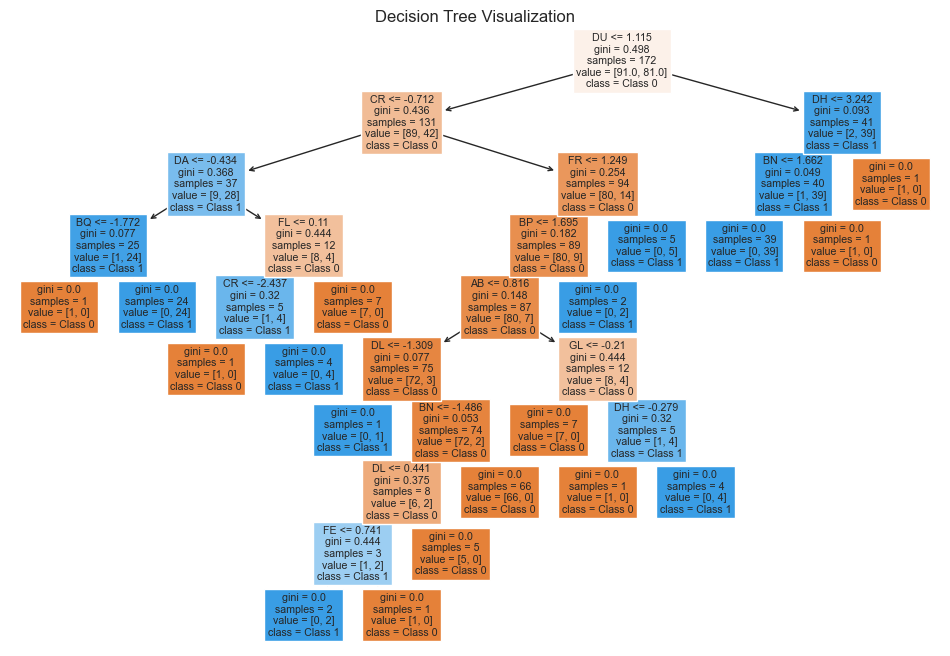

In [52]:
from sklearn.tree import plot_tree

# Визуализация дерева решений
plt.figure(figsize=(12, 8))
plot_tree(dt_resampled, filled=True, feature_names=X_resampled.columns, class_names=['Class 0', 'Class 1'])
plt.title('Decision Tree Visualization')
plt.show()

#### 3. Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
rf_resampled = RandomForestClassifier(random_state=42)
rf_resampled.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [55]:
y_pred_rf = rf_resampled.predict(X_test_resampled)
y_prob_rf = rf_resampled.predict_proba(X_test_resampled)[:, 1]

In [56]:
classification_metrics(y_test_resampled, y_pred_rf, y_prob_rf)

Accuracy: 0.8863636363636364
Classification Report:               precision    recall  f1-score   support

           0       0.77      1.00      0.87        17
           1       1.00      0.81      0.90        27

    accuracy                           0.89        44
   macro avg       0.89      0.91      0.88        44
weighted avg       0.91      0.89      0.89        44

ROC AUC: 0.971677559912854


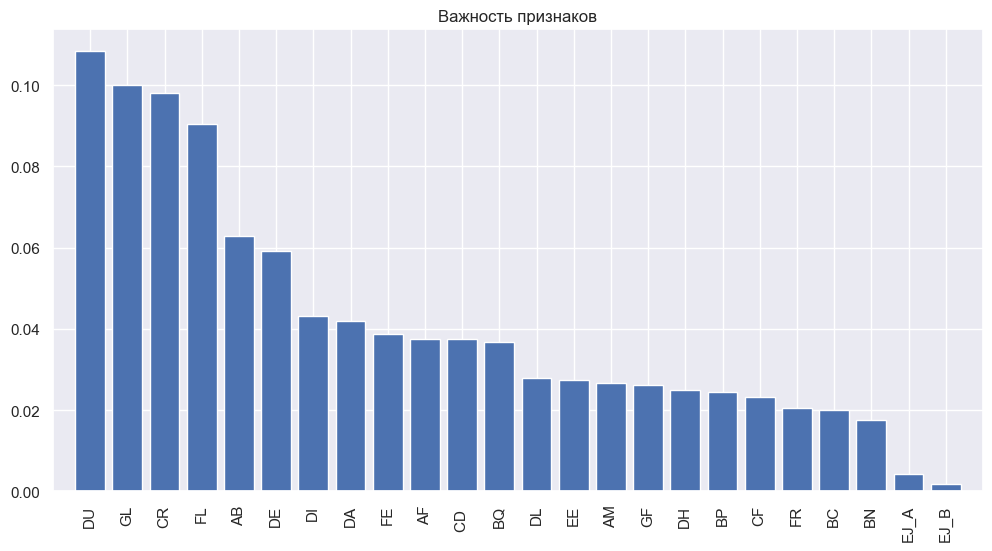

In [57]:
importances = rf_resampled.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Важность признаков')
plt.bar(range(X_resampled.shape[1]), importances[indices], align='center')
plt.xticks(range(X_resampled.shape[1]), X_resampled.columns[indices], rotation=90)
plt.xlim([-1, X_resampled.shape[1]])
plt.show()

#### 4. XGBoost

In [58]:
from xgboost import XGBClassifier

In [59]:
xgb_resampled = XGBClassifier()
xgb_resampled.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [60]:
y_pred_xgb = xgb_resampled.predict(X_test_resampled)
y_prob_xgb = xgb_resampled.predict_proba(X_test_resampled)[:, 1]

In [61]:
classification_metrics(y_test_resampled, y_pred_xgb, y_prob_xgb)

Accuracy: 0.9318181818181818
Classification Report:               precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.96      0.93      0.94        27

    accuracy                           0.93        44
   macro avg       0.93      0.93      0.93        44
weighted avg       0.93      0.93      0.93        44

ROC AUC: 0.9825708061002179


#### 5. SVM

In [62]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [63]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],  # Параметр регуляризации
    'gamma': ['scale', 'auto']  # Параметр для 'rbf', 'poly' и 'sigmoid'
}

In [64]:
svm = SVC(probability=True)

In [65]:
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search_svm.fit(X_train_resampled, y_train_resampled)
best_params_svm = grid_search_svm.best_params_
best_model_svm = grid_search_svm.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [66]:
y_pred_svm = best_model_svm.predict(X_test_resampled)
y_prob_svm = best_model_svm.predict_proba(X_test_resampled)[:, 1]  # Вероятности положительного класса

In [67]:
classification_metrics(y_test_resampled, y_pred_svm, y_prob_svm)

Accuracy: 0.8863636363636364
Classification Report:               precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.92      0.89      0.91        27

    accuracy                           0.89        44
   macro avg       0.88      0.89      0.88        44
weighted avg       0.89      0.89      0.89        44

ROC AUC: 0.9782135076252723


#### 6. Кластеризация с помощью  kNN

In [68]:
from sklearn.cluster import KMeans

In [69]:
kmeans = KMeans()

grid_search = GridSearchCV(estimator=kmeans, param_grid=dict(n_clusters=range(1, 11)), cv=5)
grid_search.fit(X_resampled)

GridSearchCV(cv=5, estimator=KMeans(), param_grid={'n_clusters': range(1, 11)})

In [70]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Лучшие параметры', best_params)
print('Лучшая инерция:', best_score)

Лучшие параметры {'n_clusters': 10}
Лучшая инерция: -868.0910276365837


In [71]:
n_clusters = 10
kmeans_resampled = KMeans(n_clusters=n_clusters).fit(X_train_resampled)

In [72]:
clusters = kmeans_resampled.predict(X_resampled)

In [73]:
clustering_metrics(X_resampled, clusters)

Silhouette Score 0.06810341403698908
Intra-cluster Distance 5.773745680816399
Inter-cluster Distance 5.707466328131901
Davies-Bouldin Index 2.389658200461393


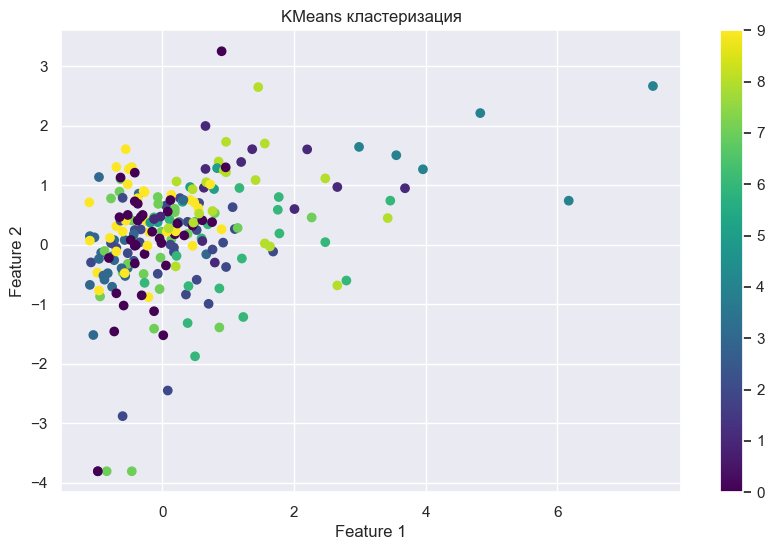

In [74]:
# Визуализация кластеров
plt.figure(figsize=(10, 6))
plt.scatter(X_resampled.iloc[:, 0], X_resampled.iloc[:, 1], c=clusters, cmap='viridis')
plt.title('KMeans кластеризация')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

#### 7. Кластеризация с помощью DBSCAN

In [75]:
from sklearn.cluster import DBSCAN

In [76]:
dbscan_resampled = DBSCAN(eps=175, min_samples=10) #eps — радиус до соседей, min_samples — минимальное кол-во соседей в радиусе
dbscan_labels = dbscan_resampled.fit_predict(X_resampled)

In [77]:
dbscan_labels = dbscan_resampled.fit_predict(X_resampled)
unique_labels = set(dbscan_labels)
print(f'Unique labels: {unique_labels}')

Unique labels: {0}


In [78]:
clustering_metrics(X_resampled, dbscan_labels)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

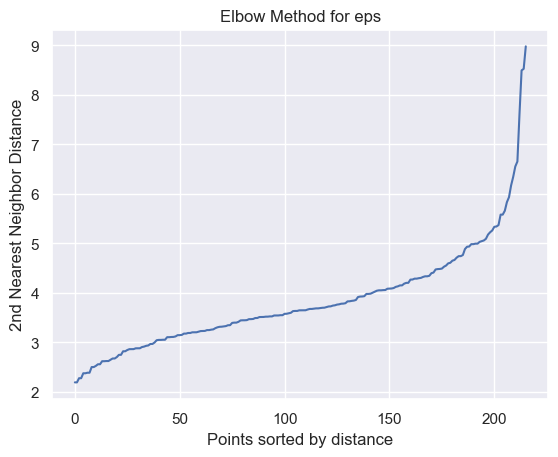

In [79]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=2)  # 2-й сосед исключает саму точку
neighbors_fit = neighbors.fit(X_resampled)
distances, indices = neighbors_fit.kneighbors(X_resampled)

# Сортируем и строим график расстояний
distances = np.sort(distances[:, 1])
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('2nd Nearest Neighbor Distance')
plt.title('Elbow Method for eps')
plt.show()

#### 8. HDBSCAN

In [80]:
import hdbscan

In [81]:
hdb = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2)
hdb_labels = hdb.fit_predict(X_resampled)

In [82]:
n_clusters = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
print('Количество кластеров:', n_clusters)

Количество кластеров: 3


In [83]:
clustering_metrics(X_resampled, hdb_labels)

Silhouette Score 0.04195574891526799
Intra-cluster Distance 5.919516561560677
Inter-cluster Distance 3.1675021223028264
Davies-Bouldin Index 2.9691502343203537


In [84]:
data_array = X_resampled.values  # Преобразование в NumPy массив

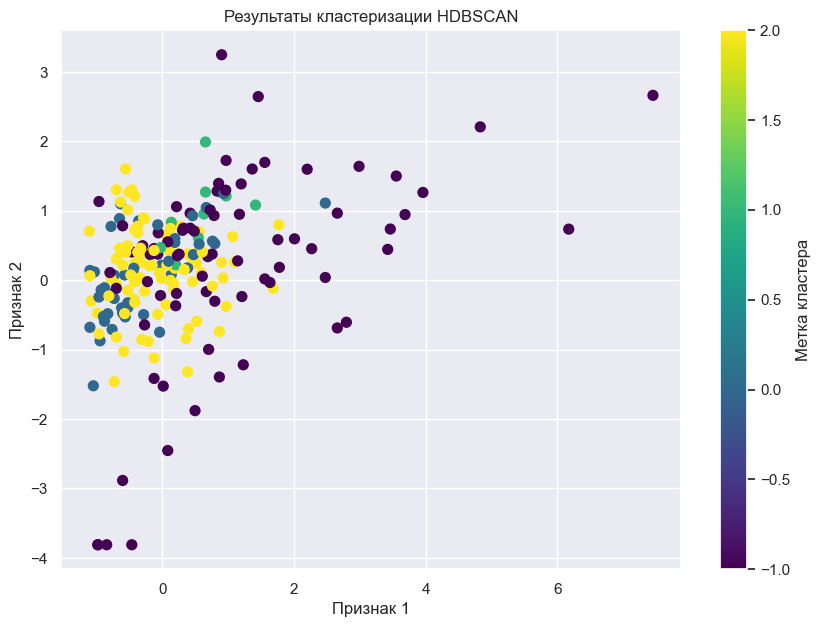

In [85]:
# Визуализация результатов
plt.figure(figsize=(10, 7))
plt.scatter(data_array[:, 0], data_array[:, 1], c=hdb_labels, cmap='viridis', marker='o', s=50)
plt.title('Результаты кластеризации HDBSCAN')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.colorbar(label='Метка кластера')
plt.show()

Поскольку DBSCAN не справился с нашим датасетом, а HDBSCAN справился — это означает, что проблема была в разреженной плотности. HDBSCAN как раз умеет выделять калстеры с разной плотностью.

# Проведем A/B-тесты и определим лучшую модель

#### Выберем лучшую модель классификации

Модифицируем функция метрик для удобства проведения A/B-тестов.

In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [87]:
def classification_metrics(y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    return accuracy, precision, recall, f1, roc_auc

Напишем функцию для сравнения метрик.

In [88]:
def compare_models(results):
    metrics_results = {}

    for model_name, metrics in results.items():
        # Сохранение метрик для каждой модели
        metrics_results[model_name] = {
            "Accuracy": metrics[0],
            "Precision": metrics[1],
            "Recall": metrics[2],
            "F1 Score": metrics[3],
            "ROC AUC": metrics[4],
        }

    # Преобразование результатов в DataFrame
    metrics_df = pd.DataFrame(metrics_results).T

    print("Результаты сравнения моделей:")
    print(metrics_df)

    # Выбор лучшей модели по каждой метрике
    for metric in metrics_df.columns:
        best_model = metrics_df[metric].idxmax()
        print(f"\nЛучшая модель по {metric}: {best_model} ({metrics_df[metric].max():.4f})")

    return metrics_df

Запишем результаты метрик в словарь.

In [89]:
results = {
    "Logistic Regression": classification_metrics(y_test_resampled, y_pred_logReg, y_prob_logReg),
    "Decision Tree": classification_metrics(y_test_resampled, y_pred_dt, y_prob_dt),
    "Random Forest": classification_metrics(y_test_resampled, y_pred_rf, y_prob_rf),
    "XGBoost": classification_metrics(y_test_resampled, y_pred_xgb, y_prob_xgb),
    "SVM": classification_metrics(y_test_resampled, y_pred_svm, y_prob_svm),
}

In [90]:
metrics_df = compare_models(results)

Результаты сравнения моделей:
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.954545   0.962963  0.962963  0.962963  0.993464
Decision Tree        0.795455   0.846154  0.814815  0.830189  0.789760
Random Forest        0.886364   1.000000  0.814815  0.897959  0.971678
XGBoost              0.931818   0.961538  0.925926  0.943396  0.982571
SVM                  0.886364   0.923077  0.888889  0.905660  0.978214

Лучшая модель по Accuracy: Logistic Regression (0.9545)

Лучшая модель по Precision: Random Forest (1.0000)

Лучшая модель по Recall: Logistic Regression (0.9630)

Лучшая модель по F1 Score: Logistic Regression (0.9630)

Лучшая модель по ROC AUC: Logistic Regression (0.9935)


Видим, что по большей части метрик наиболее точная модель классификации — это **логистическая регрессия**!

#### Выберем лучшую модель кластеризации

Снова модифицируем функцию для удобства.

In [91]:
def clustering_metrics(X, labels):
    silhouette_avg = silhouette_score(X, labels)

    intra_cluster_distances = []
    for cluster in set(labels):
        cluster_points = X[labels == cluster]
        if len(cluster_points) > 1:
            intra_cluster_distance = pairwise_distances(cluster_points).mean()
            intra_cluster_distances.append(intra_cluster_distance)
    intra_cluster_distance_avg = np.mean(intra_cluster_distances) if intra_cluster_distances else None

    inter_cluster_distances = []
    cluster_centers = []
    for cluster in set(labels):
        cluster_points = X[labels == cluster]
        cluster_center = cluster_points.mean(axis=0)
        cluster_centers.append(cluster_center)
    inter_cluster_distances = pairwise_distances(cluster_centers)
    inter_cluster_distance_avg = np.mean(inter_cluster_distances) if len(cluster_centers) > 1 else None

    db_index = davies_bouldin_score(X, labels)

    return silhouette_avg, intra_cluster_distance_avg, inter_cluster_distance_avg, db_index


In [92]:
def compare_clustering_models(results):
    metrics_results = {}

    for model_name, metrics in results.items():
        # Сохранение метрик для каждой модели
        metrics_results[model_name] = {
            "Silhouette Score": metrics[0],
            "Intra-cluster Distance": metrics[1],
            "Inter-cluster Distance": metrics[2],
            "Davies-Bouldin Index": metrics[3],
        }

    # Преобразование результатов в DataFrame
    metrics_df = pd.DataFrame(metrics_results).T

    print("Результаты сравнения моделей кластеризации:")
    print(metrics_df)

    # Выбор лучшей модели по каждой метрике
    for metric in metrics_df.columns:
        if metric == "Silhouette Score" or metric == "Inter-cluster Distance":
            best_model = metrics_df[metric].idxmax()
            best_value = metrics_df[metric].max()
        elif metric == "Intra-cluster Distance" or metric == "Davies-Bouldin Index":
            best_model = metrics_df[metric].idxmin()
            best_value = metrics_df[metric].min()

        print(f"\nЛучшая модель по {metric}: {best_model} ({best_value:.4f})")

    return metrics_df

In [93]:
results = {
    "KMeans": clustering_metrics(X_resampled, clusters),
    "HDBSCAN": clustering_metrics(X_resampled, hdb_labels),
}

In [94]:
metrics_df = compare_clustering_models(results)

Результаты сравнения моделей кластеризации:
         Silhouette Score  Intra-cluster Distance  Inter-cluster Distance  \
KMeans           0.068103                5.773746                5.707466   
HDBSCAN          0.041956                5.919517                3.167502   

         Davies-Bouldin Index  
KMeans               2.389658  
HDBSCAN              2.969150  

Лучшая модель по Silhouette Score: KMeans (0.0681)

Лучшая модель по Intra-cluster Distance: KMeans (5.7737)

Лучшая модель по Inter-cluster Distance: KMeans (5.7075)

Лучшая модель по Davies-Bouldin Index: KMeans (2.3897)


Видим, что **KMeans** абсолютно превосходит HDBSCAN по всем метрикам!